<a href="https://colab.research.google.com/github/MiguelOrtega630/IA_2025/blob/main/Probabilidad_Cancer_Cervical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Archivo cargado: /content/risk_factors_cervical_cancer.csv | Shape: (858, 36)
🔍 Buscando mejor modelo...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Mejor Modelo: {'clf': RandomForestClassifier(), 'clf__max_depth': 5, 'clf__n_estimators': 300}

📈 RESULTADOS
AUC: 0.9661208356860531
PR AUC: 0.63696410472309
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.71      0.45      0.56        11

    accuracy                           0.95       172
   macro avg       0.84      0.72      0.77       172
weighted avg       0.95      0.95      0.95       172



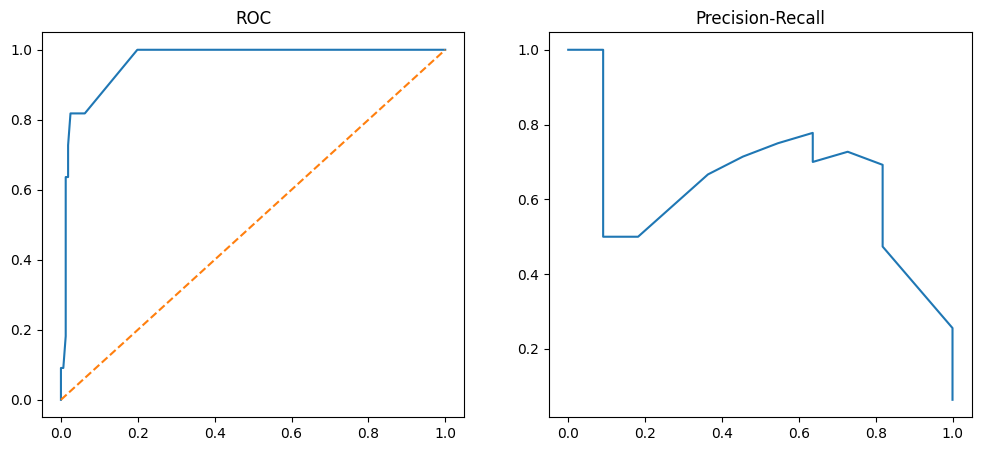

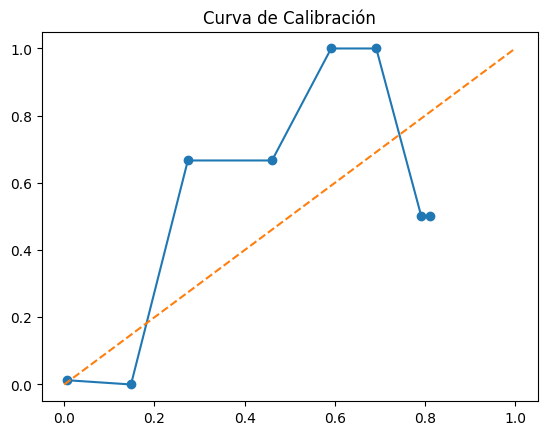

💾 Modelo guardado como modelo_cancer_cervical.joblib ✅


In [3]:
!pip install -q xgboost

import os, warnings
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings('ignore')
RANDOM_STATE = 42


file = "/content/risk_factors_cervical_cancer.csv"
df = pd.read_csv(file)

print("✅ Archivo cargado:", file, "| Shape:", df.shape)
df.head()


TARGET_COL = "Biopsy"


df[TARGET_COL] = df[TARGET_COL].replace({'?': np.nan})
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


X = X.replace('?', np.nan)
X = X.apply(pd.to_numeric, errors='coerce')

num_cols = X.columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_transformer, num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([('pre', preprocess), ('clf', LogisticRegression())])

params = [
    {'clf':[LogisticRegression(max_iter=2000)], 'clf__C':[0.01,0.1,1,10]},
    {'clf':[RandomForestClassifier()], 'clf__n_estimators':[100,300], 'clf__max_depth':[5,10,None]},
    {'clf':[XGBClassifier(eval_metric='logloss')], 'clf__n_estimators':[100,300], 'clf__max_depth':[3,6], 'clf__learning_rate':[0.01,0.1]}
]

print("🔍 Buscando mejor modelo...")
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("✅ Mejor Modelo:", grid.best_params_)


cal = CalibratedClassifierCV(best, cv=3, method='isotonic')
cal.fit(X_train, y_train)

y_proba = cal.predict_proba(X_test)[:,1]
y_pred = cal.predict(X_test)

print("\n📈 RESULTADOS")
print("AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC")
plt.subplot(1,2,2); plt.plot(rec,prec); plt.title("Precision-Recall")
plt.show()

plt.plot(prob_pred, prob_true,"o-"); plt.plot([0,1],[0,1],'--');
plt.title("Curva de Calibración")
plt.show()


joblib.dump(cal, "modelo_cancer_cervical.joblib")
print("💾 Modelo guardado como modelo_cancer_cervical.joblib ✅")